In [37]:
import glob
from pathlib import Path

import numpy as np

import matplotlib
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.constants as astcont
import astropy.units as u
from astropy.visualization import quantity_support

_ = quantity_support()
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#%matplotlib widget

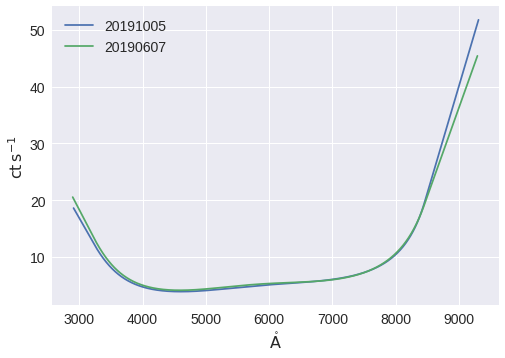

In [18]:
sens = fits.open("20191005/pypeit/Masters/gd71_sensfunc.fits")
bdsens = fits.open("20190607_ggw/pypeit/Masters/bd_28_4211_sensfunc.fits")
plt.plot(sens[1].data * u.angstrom, sens[2].data * u.count/u.second, label="20191005")
plt.plot(bdsens[1].data * u.angstrom, bdsens[2].data * u.count/u.second, label="20190607")
plt.legend()
plt.show()

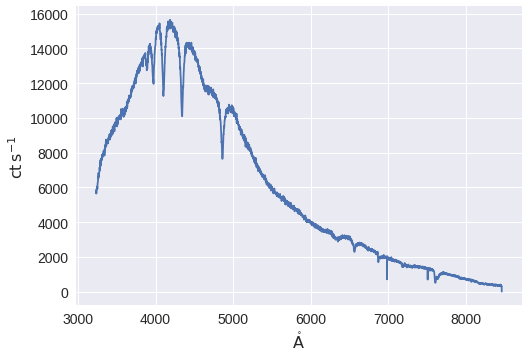

In [20]:
gd71 = Table.read("20191005/pypeit/Science/spec1d_skyobs0069-GD71_Blue_Channel_2019Oct06T105038.000.fits")
plt.plot(gd71['OPT_WAVE'] * u.angstrom, gd71['OPT_COUNTS'] * u.count/u.second)
plt.show()

In [11]:
low = Table.read("20191005/pypeit/Science/spec1d_skyobs0049-sky_az270_el20_Blue_Channel_2019Oct06T095433.000.fits")
high = Table.read("20191005/pypeit/Science/spec1d_skyobs0053-sky_az270_el47_Blue_Channel_2019Oct06T100505.000.fits")

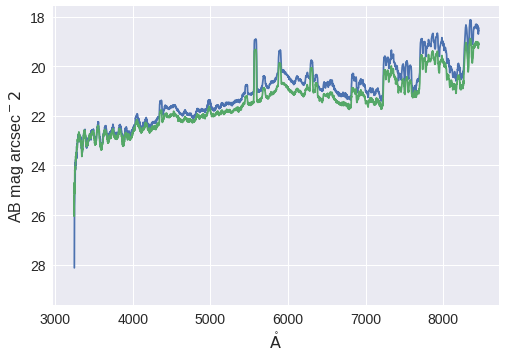

In [30]:
sens = low['OPT_FLAM'] / low['OPT_COUNTS']
cl2 = low['OPT_WAVE'] ** 2 / astcont.c.to('AA/s').value
lowflux = -2.5 * np.log10(cl2 * 1e-17 * sens * low['BOX_COUNTS_SKY'] / (low['BOX_NPIX']*5*0.6)) - 48.6
highflux = -2.5 * np.log10(cl2 * 1e-17 * sens * high['BOX_COUNTS_SKY'] / (high['BOX_NPIX']*5*0.6)) - 48.6
plt.plot(low['OPT_WAVE'] * u.angstrom, lowflux)
plt.plot(high['OPT_WAVE'] * u.angstrom, highflux)
plt.ylabel("AB mag arcsec$^-2$")
plt.gca().invert_yaxis()
plt.show()

In [26]:
def load_sky_spectrum(fitsfile, pixscale=0.6, slitwidth=5., zeropoint=48.6):
    """
    Load a Pypeit-reduced 1D sky spectrum and return wavelength in Angstroms and flux in ABmag/arcsec**2

        fitsfile: string - filename of FITS spectrum
        pixscale: float - spatial pixel scale (arcsec/pixel)
        slitwidth: float - width of the slit (arcsec)
        zeropoint: float - zeropoint for AB mag system (AB mag)
    """
    spec = Table.read(fitsfile)
    # we get the calibration function from the ratio of FLAM to COUNTS
    sensfunc = spec['OPT_FLAM'] / spec['OPT_COUNTS']
    # need lambda^2/c to convert to FNU
    cl_sq = spec['OPT_WAVE'] ** 2 / astcont.c.to('AA/s').value
    # we use the boxcar sky counts to make the extraction pixel area more deterministic
    abmag = -2.5 * np.log10(cl_sq * 1e-17 * sensfunc * spec['BOX_COUNTS_SKY'] / (spec['BOX_NPIX'] * slitwidth * pixscale)) - zeropoint
    wave = spec['OPT_WAVE'] * u.Angstrom
    abmag = abmag * u.ABmag
    return wave, abmag

In [27]:
sky1 = Table.read("../Sky1.txt", format='ascii', names=['wave', 'abmag'])
sky2 = Table.read("../Sky2.txt", format='ascii', names=['wave', 'abmag'])
sky = vstack([sky1, sky2])

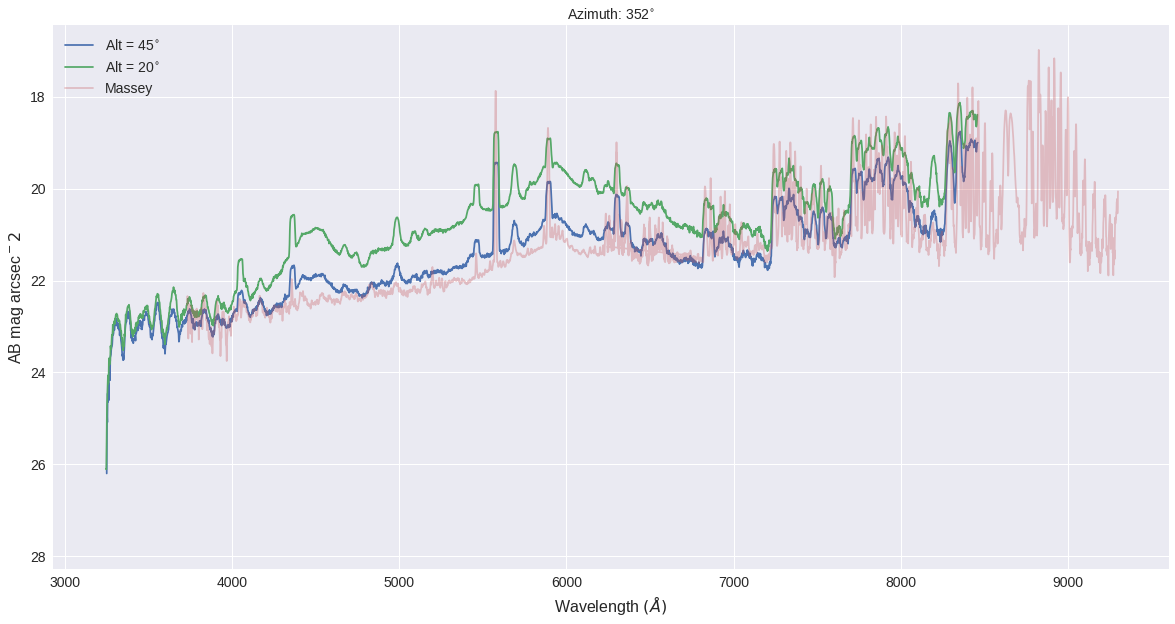

In [38]:
plt.figure(figsize=[20,10])
w, a = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0036-sky_az352_el45_Blue_Channel_2019Oct06T091809.000.fits")
wt, at = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0031-sky_az352_el20_Blue_Channel_2019Oct06T090420.000.fits")
plt.plot(w, a.value, label="Alt = 45$^{\circ}$")
plt.plot(wt, at.value, label="Alt = 20$^{\circ}$")
plt.plot(sky['wave'], sky['abmag'], alpha=0.3, label="Massey")
plt.gca().invert_yaxis()
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("AB mag arcsec$^-2$")
plt.title("Azimuth: 352$^{\circ}$")
plt.legend()
#plt.savefig("tucson.pdf")
plt.show()

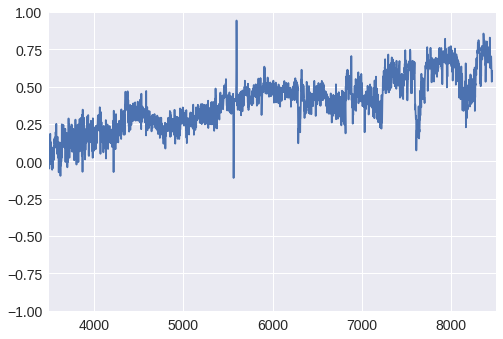

In [39]:
plt.plot(low['OPT_WAVE'], highflux - lowflux)
plt.xlim(3500, 8500)
plt.ylim(-1, 1)
plt.show()

In [13]:
# massey spectrum used 50 pix wide extraction region, 1.725"/pix, 5 pix spatial binning, and 10.2" wide slit
50 * 1.725 * 5 * 10.2

4398.75

In [40]:
oct_skyfiles = glob.glob("20191005/pypeit/Science/spec1d_*sky_az*.fits")
oct_outpath = Path("20191005/pypeit/calibrated")
for f in oct_skyfiles:
    w, a = load_sky_spectrum(f)
    p = Path(f)
    outfile = oct_outpath / f"{p.stem}.csv"
    Table([w, a], names=['wave', 'AB mag']).write(outfile)


In [41]:
june_skyfiles = glob.glob("20190607_ggw/pypeit/Science/spec1d_*sky_az*.fits")
june_outpath = Path("20190607_ggw/pypeit/calibrated")
for f in june_skyfiles:
    w, a = load_sky_spectrum(f)
    p = Path(f)
    outfile = june_outpath / f"{p.stem}.csv"
    Table([w, a], names=['wave', 'AB mag']).write(outfile)